<div style="border:solid green 2px; padding: 20px">
<b>Привет, Роман!</b>

Меня зовут Александр Пономаренко, и я буду проверять твой проект. Предлагаю общаться на «ты» :) Но если это не удобно - дай знать, и мы перейдем на "вы". 

Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать data science. Ты уже проделал большую работу над проектом, но давай сделаем его еще лучше. Ниже ты найдешь мои комментарии - **пожалуйста, не перемещай, не изменяй и не удаляй их**. Увидев у тебя ошибку, в первый раз я лишь укажу на ее наличие и дам тебе возможность самой найти и исправить ее. На реальной работе твой начальник будет поступать так же, а я пытаюсь подготовить тебя именно к работе аналитиком. Но если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> Так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Так выделены небольшие замечания. Я надеюсь, что их ты тоже учтешь - твой проект от этого станет только лучше. Но настаивать на их отработке не буду.

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Так я выделяю все остальные комментарии.</div>

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте или отвечаешь на мои комменатри — пиши об этом.** Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 

# Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

## Загрузка данных и первоначальный анализ

Импортируем необходимые методы

In [111]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer, StandardScaler, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
      
RANDOM_SEED = 1234

Запускаем спарк сессию

In [112]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California_Housing") \
                    .getOrCreate()

Читаем спарк методом данные и сохраняем в таблицу df

In [113]:
df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True) 
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Посмотрим на первые десять строк

In [114]:
df.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Не удобный формат просмотра данных, преобразуем в превычный формат Pandas

In [115]:
df_pd = df.toPandas()
df_pd.head() # просмотрим первые пять строк

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [116]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


всего строк данных - 20640

<b>В колонках датасета содержатся следующие данные:</b>

* longitude — широта;
* latitude — долгота;
* housing_median_age — медианный возраст жителей жилого массива;
* total_rooms — общее количество комнат в домах жилого массива;
* total_bedrooms — общее количество спален в домах жилого массива (<b>имеются пропуски</b>);
* population — количество человек, которые проживают в жилом массиве;
* households — количество домовладений в жилом массиве;
* median_income — медианный доход жителей жилого массива;
* median_house_value — медианная стоимость дома в жилом массиве;
* ocean_proximity — близость к океану.


все данные формата FLOAT64 кроме колонки ocean_proximity - формат object

Посмотрим статистику

In [117]:
df_pd.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* На первый взгляд данные правдоподобные, не очень ясно в чем измеряется median_income, возможно в тысячах долларов в месяц.

In [118]:
df_pd['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

* Видимо это значат следующее:

<1H OCEAN:    один час езды до океана

INLAND:        далеко от океана

NEAR OCEAN:    рядом с океаном

NEAR BAY:      рядом с бухтой

ISLAND:        остров

Просмотрим колонки 

In [119]:
columns = df_pd.columns
print(columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


* Названия колонок нормальные, править нет необходимости

Посмотрим на распределения: Создадим функцию построения гистограмм

In [120]:
def hist(col):
    plt.hist(df_pd[col], range = (df_pd[col].min(), df_pd[col].max()), bins=100, label = col)
    plt.ylabel('Частотность')
    plt.xlabel(col)
    plt.legend()
    plt.grid();

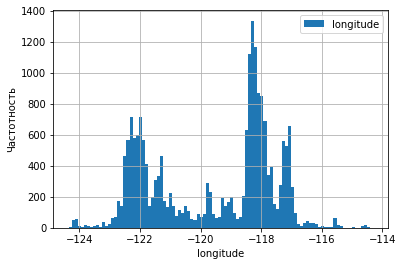

In [121]:
hist('longitude')

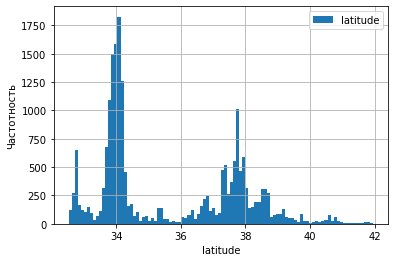

In [122]:
hist('latitude')

* Видно что в данные входят 2 крупных города

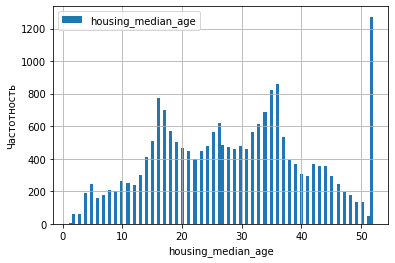

In [123]:
hist('housing_median_age')

* Видно выброс на 52 - есть предположение что либо все что получалось выше почему то запихали в 52, либо в местности достаточно много пожилого населения существенно влияющего на медианный возраст.

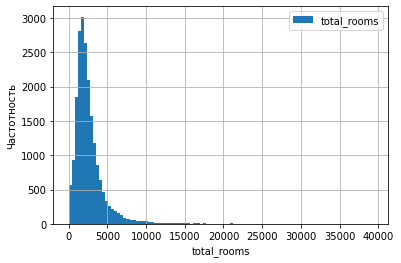

In [124]:
hist('total_rooms')

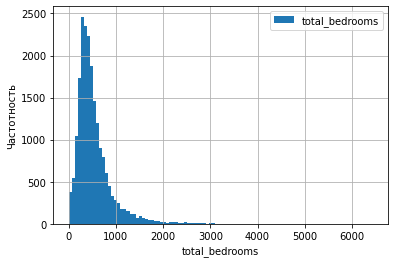

In [125]:
hist('total_bedrooms')

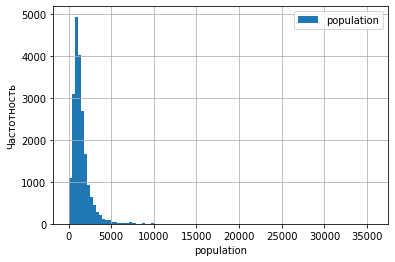

In [126]:
hist('population')

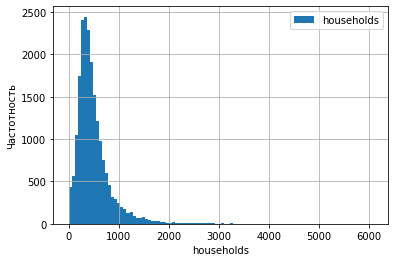

In [127]:
hist('households')

* 4 гистограммы выше вполне правдободобны, без выбросов

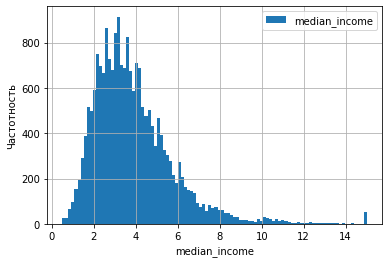

In [128]:
hist('median_income')

* Здесь есть выброс по верхнему значению медианного дохода - опять же или у тех кто выше запихали в этот максимум или действительно есть много богатых массивов влияющих на медиану.

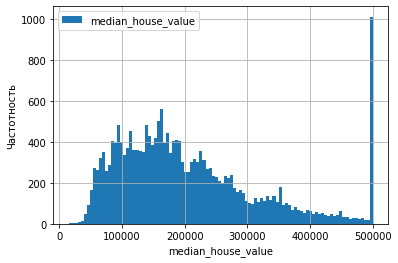

In [129]:
hist('median_house_value')

* здесь я склонен думать, что действительно есть много массивов с очень дорогими домами, хотя опять же запихивание более дорогих в эту медиану возможно.

Просмотрим таблицу корреляций

In [130]:
df_pd.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


Визуализируем корреляции:

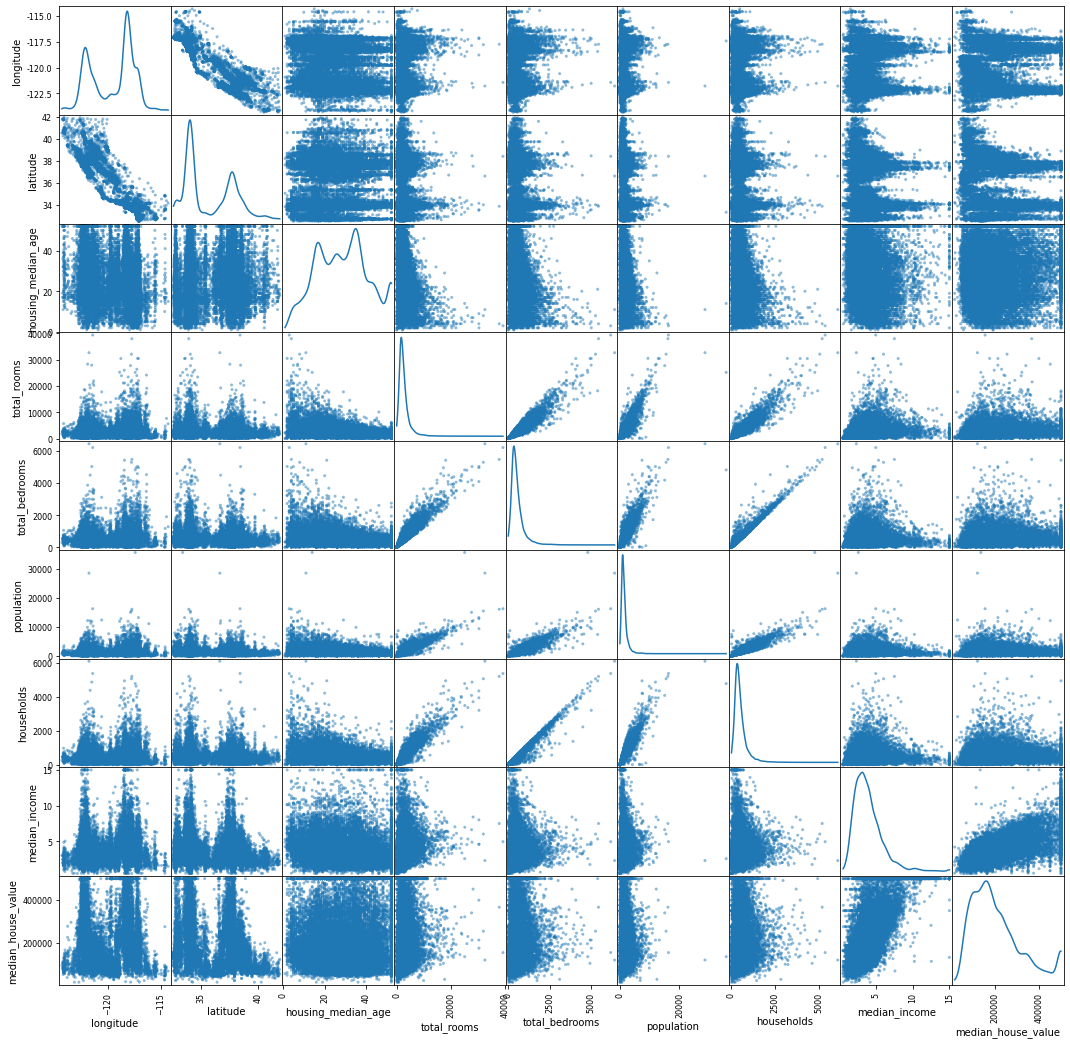

In [131]:
scatter_matrix(df_pd,diagonal='kde', figsize=(18, 18))

plt.show()

* 'total_rooms', 'total_bedrooms', 'population', 'households' по этим столбцам корреляция закономерна и понятна.

In [132]:
df_pd.duplicated().sum() #проверка на явные дубликаты

0

* Явных дубликатов нет

* <b>Вывод: </b> Данные правдоподобны, наблюдаются выбросы по максимальным значениям медианного возраста и медианной стоимости, но интерпретировать их сложно без доступа к разработчикам.


* необходимо изучить пропуски в столбце total_bedrooms и по возможности заполнить их правдоподобными значениями - как вариант выбрать медианное значение по столбцу.


* столбец ocean_proximity необходимо преобразовать из строковых значений в числовые


* столбец median_house_value является целевым для обучения

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Молодец, что проводишь EDA:)</div>

## Преобразование и подготовка данных

### Заполнение пропусков в столбце total_bedrooms

Как я понял все нужные действия преобразования нужно осуществлять уже не методами Pandas, а методами PySpark, тогда как анализ выше привычными методами Pandas нормально.

Получим среднее значение по столбцу total_bedrooms


In [133]:
mean = df.select(F.mean('total_bedrooms')).collect()[0][0]
print(mean)

537.8705525375618


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отлично, верно заполняешь пропуски</div>

Заполним пустые ячейки в столбце:

In [134]:
df = df.na.fill({'total_bedrooms': mean})

Проверим есть ли пропуски:


In [135]:
df.filter(df['total_bedrooms'].isNull()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



В столбце больше нет пропусков

### Преобразуем колонку ocean_proximity из строковых значений в числовые

In [136]:
idx = StringIndexer(inputCol = 'ocean_proximity', outputCol= 'ocean_proxi_id') 

df_x = idx.fit(df).transform(df)

df_x = df_x.drop('ocean_proximity')

df_x.toPandas().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proxi_id
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0


Метод OHE для колонки ocean_proxi_id

In [137]:
encoder = OneHotEncoder(inputCol = 'ocean_proxi_id', outputCol= 'ocean_proxi_ohe')

model = encoder.fit(df_x)

df_ohe = model.transform(df_x)

df_ohe.toPandas().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proxi_id,ocean_proxi_ohe
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0,"(0.0, 0.0, 0.0, 1.0)"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0,"(0.0, 0.0, 0.0, 1.0)"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0,"(0.0, 0.0, 0.0, 1.0)"


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Категориальные данные готовы:)</div>

### Масштабируем данные


Преобразуем все столбцы кроме median_house_value, ocean_proxi_ohe и ocean_proxi_id

Что бы потом выделить обучение только по числовым данным и добавив категориальные преобразованные OHE

In [138]:
numeric = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                  'population', 'households', 'median_income']

numeric_assy = VectorAssembler(inputCols=numeric, outputCol="num_features")

df_num = numeric_assy.transform(df_ohe) 

<div class="alert alert-info"> <b>Комментарий студента:</b> Удалил векторизацию категориальных данных</div>

numeric_ohe = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                  'population', 'households', 'median_income', 'ocean_proxi_ohe']

numeric_assy_ohe = VectorAssembler(inputCols=numeric_ohe, outputCol="num_ohe_features")

df_num = numeric_assy_ohe.transform(df_num) 

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Я думаю все же лучше будет сделать так:

+  С помощью VectorAssembler собрать числовые признаки
+  Отмасштабировать их
+  Соединить два столбца: отмасштабированные числовые признаки и категориальные данные
+  В итоге мы получим для обучения: числовые признаки и все данные

Иначе получается ты масштабируешь категориальные данные, что некорректно
</div>

In [139]:
df_num.toPandas().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proxi_id,ocean_proxi_ohe,num_features
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 12..."
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.22, 37.86, 21.0, 7099.0, 1106.0, 2401.0,..."
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.24, 37.85, 52.0, 1467.0, 190.0, 496.0, 1..."
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.25, 37.85, 52.0, 1274.0, 235.0, 558.0, 2..."
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.25, 37.85, 52.0, 1627.0, 280.0, 565.0, 2..."


Масштабируем числовые данные

In [140]:
scaler = StandardScaler(inputCol="num_features", outputCol="num_features_scale")

df_num = scaler.fit(df_num).transform(df_num) 

Массштабируем все данные

<div class="alert alert-info"> <b>Комментарий студента:</b> Удалил масштабирование категориальных данных</div>

scaler = StandardScaler(inputCol="num_ohe_features", outputCol="num_ohe_features_scale")

df_num = scaler.fit(df_num).transform(df_num) 

In [141]:
df_num.toPandas().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proxi_id,ocean_proxi_ohe,num_features,num_features_scale
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 12...","[-61.00726959606955, 17.734477624640412, 3.257..."
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.22, 37.86, 21.0, 7099.0, 1106.0, 2401.0,...","[-61.002278409814444, 17.725114120086744, 1.66..."
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.24, 37.85, 52.0, 1467.0, 190.0, 496.0, 1...","[-61.012260782324645, 17.720432367809913, 4.13..."
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.25, 37.85, 52.0, 1274.0, 235.0, 558.0, 2...","[-61.01725196857974, 17.720432367809913, 4.131..."
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.25, 37.85, 52.0, 1627.0, 280.0, 565.0, 2...","[-61.01725196857974, 17.720432367809913, 4.131..."


<div class="alert alert-info"> <b>Комментарий студента:</b> Теперь у нас есть масштабированные числовые признаки, и отдельно категоральные OHE признаки, далее векторизуем их отдельно числовые и отдельно числовые плюс категориальные.</div>



<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b>Отлично, так более корректно:) </div>

### Подготовим числовые данные и отдельно числовые и категориальные

Числовые данные

In [142]:
assy_num_features = ['num_features_scale']

assy_num = VectorAssembler(inputCols=assy_num_features, outputCol="num_assy_features") 

df_assy_num = assy_num.transform(df_num)

df_num.select(assy_num_features).show(10) 

+--------------------+
|  num_features_scale|
+--------------------+
|[-61.007269596069...|
|[-61.002278409814...|
|[-61.012260782324...|
|[-61.017251968579...|
|[-61.017251968579...|
|[-61.017251968579...|
|[-61.017251968579...|
|[-61.017251968579...|
|[-61.022243154834...|
|[-61.017251968579...|
+--------------------+
only showing top 10 rows



Числовые и OHE данные

In [143]:
assy_num_features_ohe = ['num_features_scale', 'ocean_proxi_ohe']

assy_num_ohe = VectorAssembler(inputCols=assy_num_features_ohe, outputCol="num_assy_features_ohe") 

df_assy_num_ohe = assy_num_ohe.transform(df_num)

df_num.select(assy_num_features_ohe).show(10) 

+--------------------+---------------+
|  num_features_scale|ocean_proxi_ohe|
+--------------------+---------------+
|[-61.007269596069...|  (4,[3],[1.0])|
|[-61.002278409814...|  (4,[3],[1.0])|
|[-61.012260782324...|  (4,[3],[1.0])|
|[-61.017251968579...|  (4,[3],[1.0])|
|[-61.017251968579...|  (4,[3],[1.0])|
|[-61.017251968579...|  (4,[3],[1.0])|
|[-61.017251968579...|  (4,[3],[1.0])|
|[-61.017251968579...|  (4,[3],[1.0])|
|[-61.022243154834...|  (4,[3],[1.0])|
|[-61.017251968579...|  (4,[3],[1.0])|
+--------------------+---------------+
only showing top 10 rows



Далее разделим эти два типа данных на выборки, признаки и цели.

### Разделение на тренировочную, тестовую выборки только с числами

In [144]:
num_train, num_test = df_assy_num.randomSplit([.8,.2], seed=RANDOM_SEED)

In [145]:
num_train.count()

16525

In [146]:
num_test.count()

4115

### Разделение на тренировочную, тестовую выборки c числами и категориями


In [147]:
ohe_train, ohe_test = df_assy_num_ohe.randomSplit([.8,.2], seed=RANDOM_SEED)

In [148]:
ohe_train.count()

16525

In [149]:
ohe_test.count()

4115

Целевой признак у нас  в столбце median_house_value

In [150]:
target = 'median_house_value'

## Обучение моделей только c числовыми данными  и числовые и категориальные данные

### Модель только числовые данные

In [151]:
lr_num = LinearRegression(featuresCol = "num_assy_features", labelCol = target)
# инициализируем модель LinearRegression со стандартными параметрами

model_num = lr_num.fit(num_train) # обучаем на тренировочной выборке

predict_num = model_num.transform(num_test) # предсказания на тестовой выборке

predicted_num = predict_num.select("median_house_value", "prediction")

predicted_num.show(10) 

22/03/24 18:29:50 WARN Instrumentation: [d3ec01e8] regParam is zero, which might cause numerical instability and overfitting.


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           85800.0|65406.499051048886|
|          111400.0|163959.10368145583|
|           70500.0|110449.31434640894|
|          128900.0|174640.75948076276|
|          116100.0|201286.86867628153|
|           82800.0| 139221.2239002143|
|           81300.0|118120.68743157014|
|           85600.0|155974.80378930783|
|           80500.0|149054.29987108056|
|           75500.0|100177.29116967926|
+------------------+------------------+
only showing top 10 rows



### Модель числовые и OHE данные

In [152]:
lr_ohe = LinearRegression(featuresCol = "num_assy_features_ohe", labelCol = target)
# инициализируем модель LinearRegression со стандартными параметрами

model_ohe = lr_ohe.fit(ohe_train) # обучаем на тренировочной выборке

predict_ohe = model_ohe.transform(ohe_test) # предсказания на тестовой выборке

predicted_ohe = predict_ohe.select("median_house_value", "prediction")

predicted_ohe.show(10) 

22/03/24 18:29:52 WARN Instrumentation: [43270253] regParam is zero, which might cause numerical instability and overfitting.


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           85800.0|116551.81495520682|
|          111400.0|191334.81842447794|
|           70500.0|   144430.11994486|
|          128900.0|208216.35852627107|
|          116100.0| 234876.1625952029|
|           82800.0|172811.15500129317|
|           81300.0|152286.61389328795|
|           85600.0|188892.50422514626|
|           80500.0|180578.49481481058|
|           75500.0|139036.33232905925|
+------------------+------------------+
only showing top 10 rows



<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Отлично, обучение провел верно:)</div>

## Для оценки качества модели используйте метрики RMSE, MAE и R2

### Модель только числовые признаки

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Вот так можно проверить на тесте:)</div>

#КОД РЕВЬЮЕРА

RMSE = RegressionEvaluator(labelCol=target).evaluate(predict_num)

MAE = RegressionEvaluator(labelCol=target, metricName='mae').evaluate(predict_num)

R2 = RegressionEvaluator(labelCol=target, metricName='r2').evaluate(predict_num)

print('RMSE: ', RMSE)
print('MAE: ', MAE)
print('R2: ', R2)

<div class="alert alert-info"> <b>Комментарий студента:</b> Начало исправления</div>

In [153]:
RMSE_num = RegressionEvaluator(labelCol=target).evaluate(predict_num)
MAE_num = RegressionEvaluator(labelCol=target, metricName='mae').evaluate(predict_num)
R2_num = RegressionEvaluator(labelCol=target, metricName='r2').evaluate(predict_num)

In [154]:
print('RMSE -  модель обучается только на числовых', round(RMSE_num,4))

RMSE -  модель обучается только на числовых 68181.4616


In [155]:
print('MAE - модели обученной на всех признаках:', round(MAE_num,4))

MAE - модели обученной на всех признаках: 50390.8325


In [156]:
print('Качество - модели обученной на всех признаках::', R2_num)

Качество - модели обученной на всех признаках:: 0.6458087926585567


<div class="alert alert-info"> <b>Комментарий студента:</b> Конец исправления</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> В данном случае ты смотришь метрики на обучающей выборке
</div>

### Модель числовые и категориальные признаки

RMSE MAE R2

RMSE = RegressionEvaluator(labelCol=target).evaluate(predictions_full)

MAE = RegressionEvaluator(labelCol=target, metricName='mae').evaluate(predictions_full)

R2 = RegressionEvaluator(labelCol=target, metricName='r2').evaluate(predictions_full)

print('RMSE: ', RMSE)
print('MAE: ', MAE)
print('R2: ', R2)

<div class="alert alert-info"> <b>Комментарий студента:</b> Начало исправления</div>

In [157]:
RMSE_ohe = RegressionEvaluator(labelCol=target).evaluate(predict_ohe)
MAE_ohe = RegressionEvaluator(labelCol=target, metricName='mae').evaluate(predict_ohe)
R2_ohe = RegressionEvaluator(labelCol=target, metricName='r2').evaluate(predict_ohe)

In [158]:
print('RMSE -  модель обучается на числовых и категориальных', round(RMSE_ohe,4))

RMSE -  модель обучается на числовых и категориальных 67366.418


In [159]:
print('MAE - модель обучается на числовых и категориальных', round(MAE_ohe,4))

MAE - модель обучается на числовых и категориальных 49216.7416


In [160]:
print('Качество - модель обучается на числовых и категориальных:', R2_ohe)

Качество - модель обучается на числовых и категориальных: 0.6542262076010923


<div class="alert alert-info"> <b>Комментарий студента:</b> Конец исправления</div>

<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b>Теперь все верно:) </div>

### Сравнительная таблица обучения модели на разных наборах признаков

In [161]:
tab = pd.DataFrame(data=[['num',RMSE_num,MAE_num,R2_num],
                         ['categorical + num',RMSE_ohe,MAE_ohe,R2_ohe]],
                   columns=['model','RMSE', 'MAE', 'R2'])

In [162]:
display(tab)

,model,RMSE,MAE,R2
0,num,68181.461564,50390.832460,0.645809
1,categorical + num,67366.417956,49216.741617,0.654226


Посмотрим данные:


In [163]:
df_pd['median_house_value'].min()

14999.0

In [164]:
df_pd['median_house_value'].max()

500001.0

In [165]:
df_pd['median_house_value'].mean()

206855.81690891474

<div class="alert alert-info"> <b>Комментарий студента:</b> На тестовой выборке значения улучшились даже и когда просто объеденил категориальные данные без масштабирования и числовые, так же показатели, по второй строке, чуть чуть улучшились</div>

Разброс значений предсказаний достаточной большой

# Анализ результатов

<b>Основным выводом является:</b> регистрация небольшой зависимости в точности модели предсказания от наличия категориальных данных, правда разница невелика. Из этого можно сделать закономерный вывод, что если при сборе данных о жилье ввести еще дополнительные параметры или категории для описания, то возможно еще увеличение точности предсказаний.

Так же по результату работы увидел разницу между машинным обучением обычными методами Pandas и методами pyspark, во многих местах было весьма непривычно применять другие принципы работы с кодом, и все время пытался перескочить на уже изученные методы Pandas, что давало ошибки - работа pyspark с типами данных string, а не list и dataframe.

Так же так и не решен вопрос почему локально не запускается спарк сессия (java gateway), поэтому пришлось проект делать сразу на платформе. После обновления на новую версию pyspark пришлось немного поправить код из-за возникающих ошибок, тоже было интересно сравнить версии.

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Роман , получился хороший проект! 
    
Если есть  если есть какие либо вопросы я с удовольствием на них отвечу:) <br> Исправь, пожалуйста, замечания и жду проект на следующую проверку:) </div>


<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b>Удачи в следующих проектах!!!

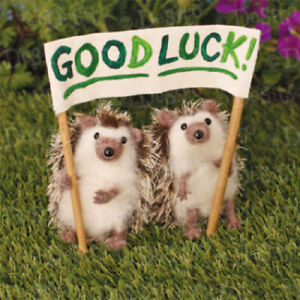

</div>